# 05 - Taming Text

In [59]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment import *
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
%matplotlib inline

In [2]:
# import data
directory = 'hillary-clinton-emails/'
aliases = pd.read_csv(directory+'aliases.csv')
email_receivers = pd.read_csv(directory+'EmailReceivers.csv')
emails = pd.read_csv(directory+'Emails.csv')
persons = pd.read_csv(directory+'Persons.csv')

### Comparison between extracted body text and raw text

In [36]:
i = 2
print(emails['ExtractedBodyText'][i], '\n\n END OF BODY TEXT \n\n', emails['RawText'][i])


Thx 

 END OF BODY TEXT 

 UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From: Mills, Cheryl D <MillsCD@state.gov>
Sent: Wednesday, September 12, 2012 11:52 AM
To: B6
Cc: Abedin, Huma
Subject: Re: Chris Stevens
Thx
Original Message
From: Anne-Marie Slaughter [
Sent: Wednesday, September 12, 2012 07:46 AM
To: Ihdr22@clintonernail.com' <hdr22@clintonemail corn>
Cc: Abed in, Huma; Mills, Cheryl D
Subject: Chris Stevens
To you and all my former colleagues, I'm so terribly sorry. Our FSOs stand on the front lines just as surely and devotedly
as our soldiers do. Thinking of you and Pat and everyone this morning.
AM
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE IN

By reading a few emails we can see that the extracted body text is just the text that the email sender wrote (as stated on Kaggle) while the raw text gathers the previous emails forwarded or the whole discussion. Note that the extracted body text can sometimes contain NaNs. By including repeated messages in the raw text, you induce bias in the distribution of the words, thus we kept only the body text

## 1. Worldclouds

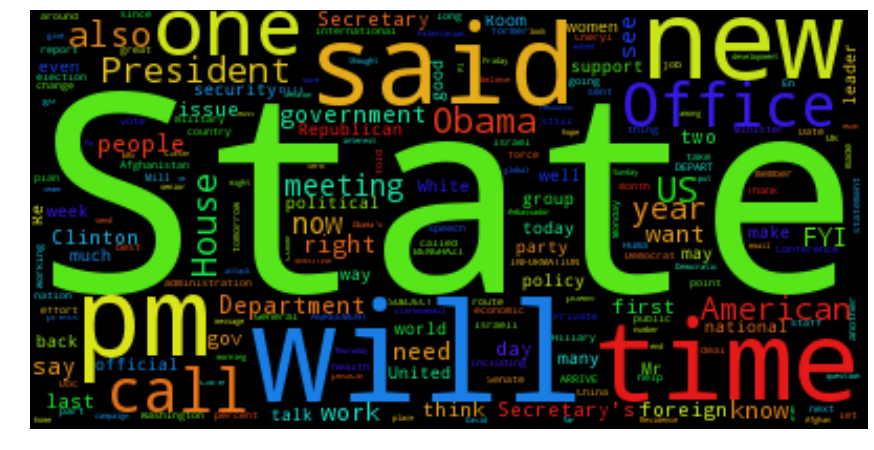

In [37]:
# raw corpus
text_corpus = emails.ExtractedBodyText.dropna().values
raw_text = ' '.join(text_corpus)

# generate wordcloud
wordcloud = WordCloud().generate(raw_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off');

In [38]:
def preprocess(text=raw_text):
    print('Length of raw text: ', len(raw_text))
    
    # tokenization (need to install models/punk from nltk.download())
    tokens = nltk.word_tokenize(raw_text, language='english')
    print('Number of tokens extracted: ', len(tokens))
    
    # stopwords removal (need to install stopwords corpus in corpora/stopwords)
    # cach stopwords to improve performance (70x speedup)
    cached_stopwords = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in cached_stopwords]
    print('Number of tokens after stopword removal: ', len(filtered_tokens))
    
    # stemming
    stemmer = nltk.SnowballStemmer('english')
    stemmed_filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]
    
    # dump array in text file
    output = ' '.join(stemmed_filtered_tokens)
    with open("preprocessed_text.txt", "w") as text_file:
        text_file.write(output)
        
preprocess()

Length of raw text:  3601322
Number of tokens extracted:  697009
Number of tokens after stopword removal:  475544


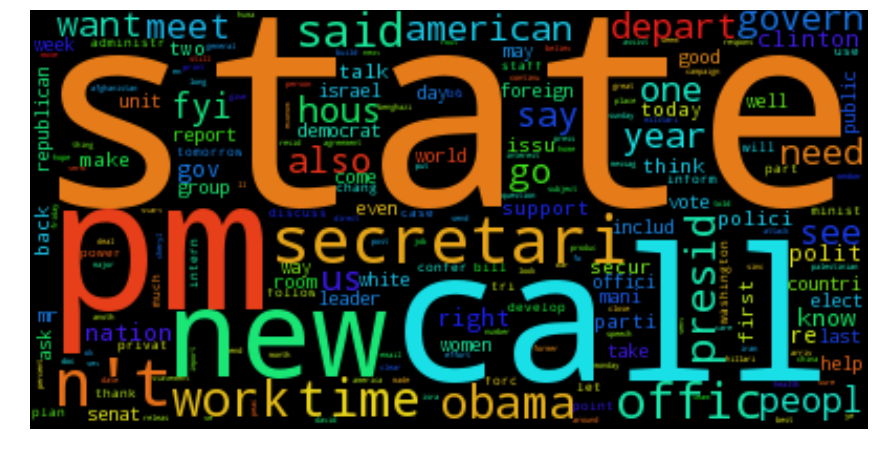

In [39]:
preprocessed_text = open('preprocessed_text.txt').read()
wordcloud2 = WordCloud().generate(preprocessed_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud2)
plt.axis('off');

## Comparison between the word clouds

Looking at the wordcloud generated after having preprocessed the data, it seems that stemming hurt the "performance" of the wordcloud, indeed a number of words have been incorrectly stemmed e.g. department has been reduced to depart, secretary to secretary, message to messag and so on.

## 2. Sentiment analysis
from [this link](https://www.kaggle.com/ampaho/d/kaggle/hillary-clinton-emails/foreign-policy-map-through-hrc-s-emails/code),we added the following words to be removed:
* add "RE" because the iso3 code for Reunion islands.. but it appears a lot in emails to indicate the RE(sponses) to previous emails.
* FM
* TV is ISO2 code for Tuvalu but also refers to Television
* AL is a given name and also ISO2 for Albania
* BEN is a given name and also ISO3 for Benin
* LA is Los angeles and iso 2 for Lao
* AQ is abbreviation of "As Quoted" and iso 2 for Antarctica

After a few runs, we looked at the (unusual) countries extracted. We noticed that an important number of emails have words capitalized and thus added the following stopwords:
* AND is ISO3 for Andorra
* AM is ISO2 for Armenia 
* AT is ISO2 for Austria
* IN is ISO2 for India
* NO is ISO2 for Norway
* PM is iSO2 for Saint Pierre and Miquelon
* TO is ISO2 for Tonga
* BY is ISO2 for Belarus

In [40]:
def find_countries(tokens):
    # find countries in a list of token
    countries = []
    for token in tokens:
        try:
            # search for any alpha_2 country name e.g. US, CH
            country = pycountry.countries.get(alpha_2=token)
            countries.append(country.name)            
        except KeyError:
            try:
                # search for any alpha_3 country name e.g. USA, CHE
                country = pycountry.countries.get(alpha_3=token)
                countries.append(country.name)
            except KeyError:
                try:
                    # search for a country by its name, title() upper cases every first letter but lower cases
                    # the other, hence it is handled last, but it deals with country names such as switzerland
                    country = pycountry.countries.get(name=token.title())
                    countries.append(country.name)
                except KeyError: pass
    return list(set(countries))

In [41]:
def foreign_policy(emails, sentiment_analyzer):
    start_time = time.time()
    words_to_be_removed = ["RE", "FM", "TV", "LA", "AL", "BEN", "AQ", "AND", "AM", "AT", "IN", "NO", "PM", "TO",
                          "BY"]
    vader_analyzer = SentimentIntensityAnalyzer()
    foreign_policy = {}
    cached_stopwords = set(stopwords.words('english'))
    cached_stopwords.update(words_to_be_removed)
    i=0

    for email in emails: # TODO: regex instead of tokens lookup parce que ca prend trop de teeeeemps
        print('{:d} / {:d} emails processed'.format(i, len(emails)))
        tokens = nltk.word_tokenize(email, language='english')
        tokens = [word for word in tokens if word not in cached_stopwords]
        # country lookup in tokens
        countries = find_countries(tokens)
        i +=1
        if not countries: continue
        
        if sentiment_analyzer =='vader':
            sentiment = vader_analyzer.polarity_scores(email)
            score = sentiment['compound']
        #elif sentiment_analyzer ==''
              
        for country in countries:
            if not country in foreign_policy.keys():
                foreign_policy.update({country: [score, 1]})
            else:
                foreign_policy[country][0] += score
                foreign_policy[country][1] += 1
    for country, value in foreign_policy.items():
        foreign_policy.update({country: [(value[0]/value[1]), value[1]]})
    print("--- %s seconds elapsed ---" % (time.time() - start_time))
    return foreign_policy

In [42]:
foreign_policy = foreign_policy(text_corpus[:1000], sentiment_analyzer='vader')

0 / 6742 emails processed
1 / 6742 emails processed
2 / 6742 emails processed
3 / 6742 emails processed
4 / 6742 emails processed
5 / 6742 emails processed
6 / 6742 emails processed
7 / 6742 emails processed
8 / 6742 emails processed
9 / 6742 emails processed
10 / 6742 emails processed
11 / 6742 emails processed
12 / 6742 emails processed
13 / 6742 emails processed
14 / 6742 emails processed
15 / 6742 emails processed
16 / 6742 emails processed
17 / 6742 emails processed
18 / 6742 emails processed
19 / 6742 emails processed
20 / 6742 emails processed
21 / 6742 emails processed
22 / 6742 emails processed
23 / 6742 emails processed
24 / 6742 emails processed
25 / 6742 emails processed
26 / 6742 emails processed
27 / 6742 emails processed
28 / 6742 emails processed
29 / 6742 emails processed
30 / 6742 emails processed
31 / 6742 emails processed
32 / 6742 emails processed
33 / 6742 emails processed
34 / 6742 emails processed
35 / 6742 emails processed
36 / 6742 emails processed
37 / 6742 e

In [54]:
pycountry.countries.get(name='Ireland')

Country(alpha_2='IE', alpha_3='IRL', name='Ireland', numeric='372')

### Plotting the foreign policy

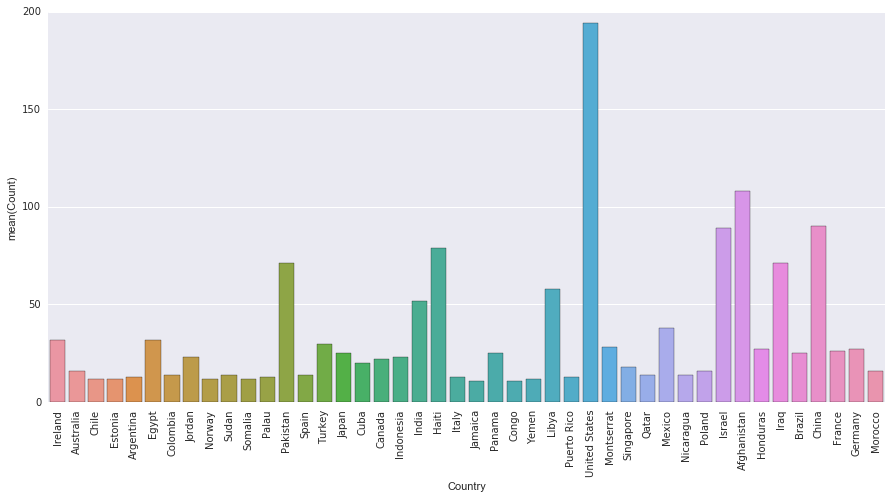

In [96]:
df = pd.DataFrame.from_dict(foreign_policy, orient='index')
df.reset_index(inplace=True)
df.columns =['Country', 'Sentiment', 'Count']
df = df[df['Count'] > 10]
plt.figure(figsize=(15,7))
plot = sns.barplot(x='Country', y='Count', data=df, orient='vertical')
plt.xticks(rotation=90);

In [45]:
pycountry.countries.get(name='Palau')

Country(alpha_2='PW', alpha_3='PLW', name='Palau', numeric='585', official_name='Republic of Palau')

In [55]:
test_sentence = "and here I am AM TO speaking of France"
cached_stopwords = set(stopwords.words('english'))
words_to_be_removed = ["RE", "FM", "TV", "LA", "AL", "BEN", "AQ", "AND", "AM", "AT"]
cached_stopwords.update(words_to_be_removed)
tokens = nltk.word_tokenize(test_sentence)
tokens = [word for word in tokens if word not in cached_stopwords]
countries = find_countries(tokens)
print(countries)

['Tonga', 'France']


In [ ]:
test_sentence = 'This is a very pleasant day.'
#test_sentence = 'this is a completely neutral sentence'
polarity = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
vader_analyzer = SentimentIntensityAnalyzer()
tokens = nltk.word_tokenize(test_sentence)
#tokens.remove('is')
result = ' '.join(tokens)
sentiment = vader_analyzer.polarity_scores(result)
#mean = -sentiment['neg'] + sentiment['pos']
#print(sentiment, mean)
np.max(sentiment.values())

In [ ]:
test_set = ['nice nice good USA US switzerland', 'bad good bad bad bad libya', 'Switzerland good nice nice']
words_to_be_removed = ["RE", "FM", "TV", "LA", "AL", "BEN", "AQ"]
vader_analyzer = SentimentIntensityAnalyzer()
country_counts = {}
country_sentiments = {}
foreign_policy = {}
for email in test_set:
    tokens = nltk.word_tokenize(email, language='english')
    tokens = [word for word in tokens if word not in words_to_be_removed]
    clean_email = ' '.join(tokens)
    sentiment = vader_analyzer.polarity_scores(clean_email)
    score = sentiment['compound']
    # country lookup in raw text 
    countries = find_countries(tokens)
    for country in countries:
        if not country in foreign_policy.keys():
            foreign_policy.update({country: [score, 1]})
        else:
            foreign_policy[country][0] += score
            foreign_policy[country][1] += 1

for country, value in foreign_policy.items():
    foreign_policy.update({country: [(value[0]/value[1]), value[1]]})